<a href="https://colab.research.google.com/github/KhudV/graduation_paper_code/blob/main/%D0%92%D0%9A%D0%A0_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

torch.manual_seed(88)

In [ ]:
device = "cpu"

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 89766107.41it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9421037.01it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35239133.56it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4343485.81it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

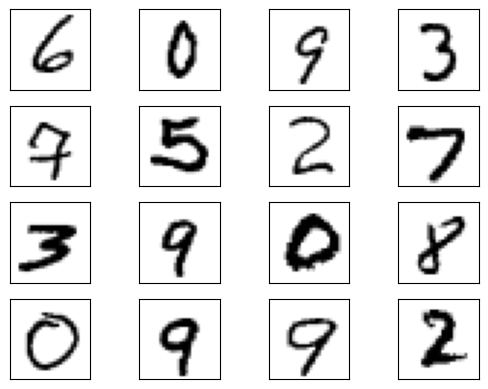

In [ ]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
discriminator = Discriminator().to(device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Epoch: 0 Loss D.: 0.5623092651367188
Epoch: 0 Loss G.: 0.5056619048118591
Epoch: 1 Loss D.: 0.14323389530181885
Epoch: 1 Loss G.: 5.434233665466309
Epoch: 2 Loss D.: 0.0062341708689928055
Epoch: 2 Loss G.: 10.877551078796387
Epoch: 3 Loss D.: 0.05558568611741066
Epoch: 3 Loss G.: 5.087135314941406
Epoch: 4 Loss D.: 0.026818132027983665
Epoch: 4 Loss G.: 4.694355010986328
Epoch: 5 Loss D.: 0.09459538757801056
Epoch: 5 Loss G.: 3.8155670166015625
Epoch: 6 Loss D.: 0.16762645542621613
Epoch: 6 Loss G.: 4.458575248718262
Epoch: 7 Loss D.: 0.25763121247291565
Epoch: 7 Loss G.: 4.510554313659668
Epoch: 8 Loss D.: 0.18826138973236084
Epoch: 8 Loss G.: 3.4598886966705322
Epoch: 9 Loss D.: 0.27417588233947754
Epoch: 9 Loss G.: 2.6122214794158936
Epoch: 10 Loss D.: 0.30595076084136963
Epoch: 10 Loss G.: 1.763994812965393
Epoch: 11 Loss D.: 0.44813084602355957
Epoch: 11 Loss G.: 2.011451482772827
Epoch: 12 Loss D.: 0.426442950963974
Epoch: 12 Loss G.: 1.8171230554580688
Epoch: 13 Loss D.: 0.33917

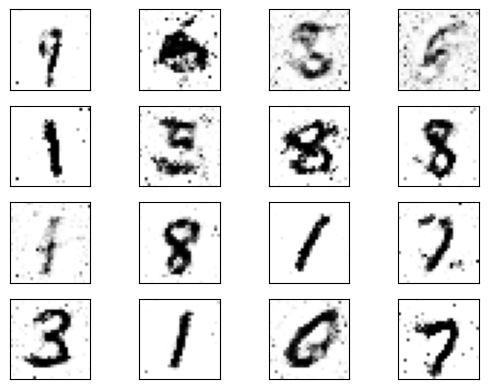

In [ ]:
%%time
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Показываем loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            if epoch % 10 == 0:
              generated_samples = generated_samples.detach()
              for i in range(16):
                ax = plt.subplot(4, 4, i + 1)
                plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
                plt.xticks([])
                plt.yticks([])

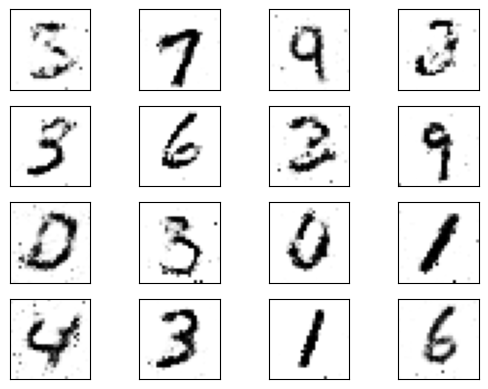

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
torch.save(discriminator.state_dict(), "/content/drive/MyDrive/ВКР/discriminator.pth")
torch.save(generator.state_dict(), "/content/drive/MyDrive/ВКР/generator.pth")

In [ ]:
#Later to restore:
discriminator.load_state_dict(torch.load("/content/drive/MyDrive/ВКР/discriminator.pth"))
discriminator.eval()

generator.load_state_dict(torch.load("/content/drive/MyDrive/ВКР/generator.pth"))
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)